In [3]:
pip install bayesian-optimization

In [4]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.6 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import openpyxl
#warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from bayes_opt import BayesianOptimization

In [6]:
california_housing = fetch_california_housing()
df = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
df['MedHouseVal'] = california_housing.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


##  EDA

In [9]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


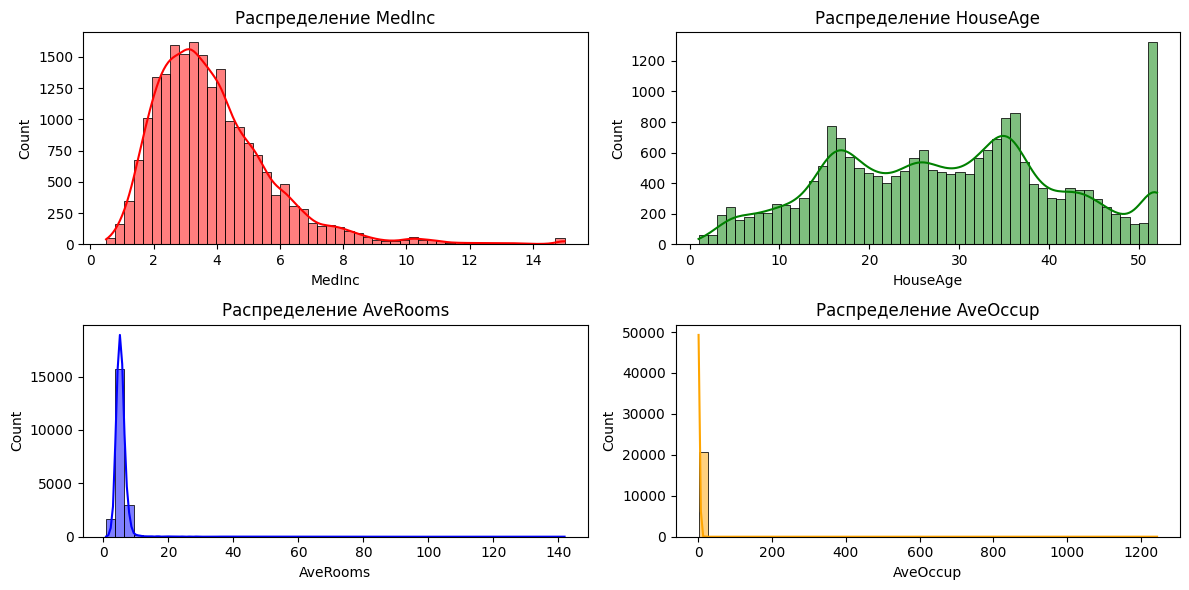

In [10]:
def hist(plt=None, col='MedHouseVal', colori='red'):
      sns.histplot(df[col], bins=50, kde=True, color=colori)
      plt.title(f'Распределение {col}')

def show_hist(columns_show=['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']):
      colors=['red', 'green', 'blue', 'orange']

      plt.figure(figsize=(12,6))
      for i, col in enumerate(columns_show):
          plt.subplot(2,2,i+1)
          def hist(plt=plt, col=col, colori=colors[i]):
            sns.histplot(df[col], bins=50, kde=True, color=colori)
            plt.title(f'Распределение {col}')

          hist(plt=plt, col=col, colori=colors[i])

      plt.tight_layout()
      plt.show()

show_hist()

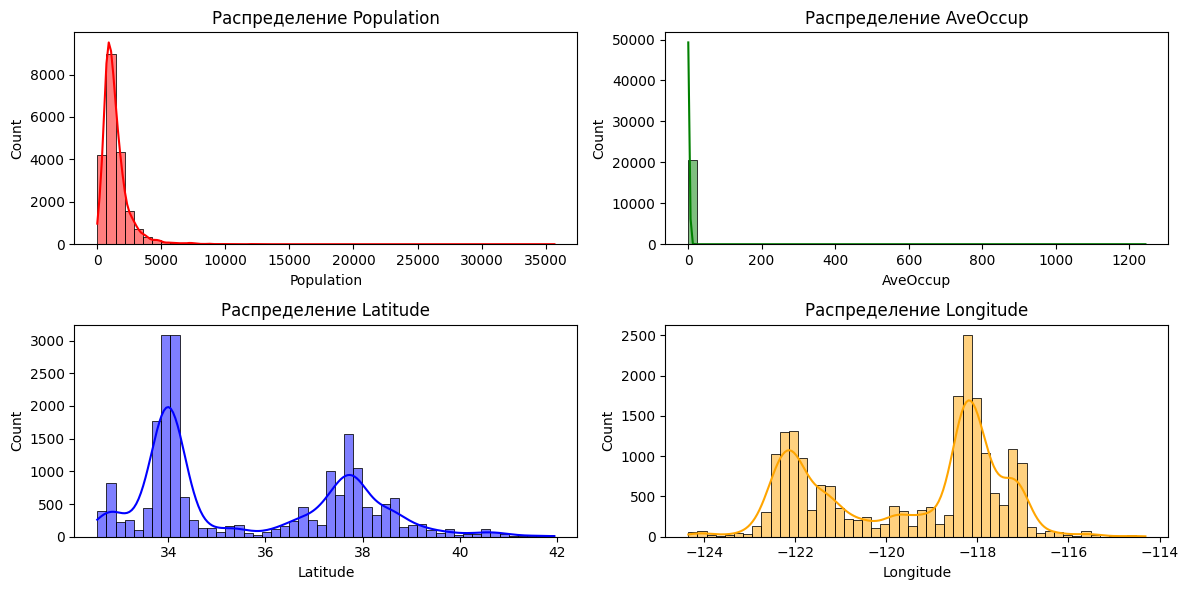

In [11]:
show_hist(columns_show=['Population', 'AveOccup', 'Latitude', 'Longitude'])

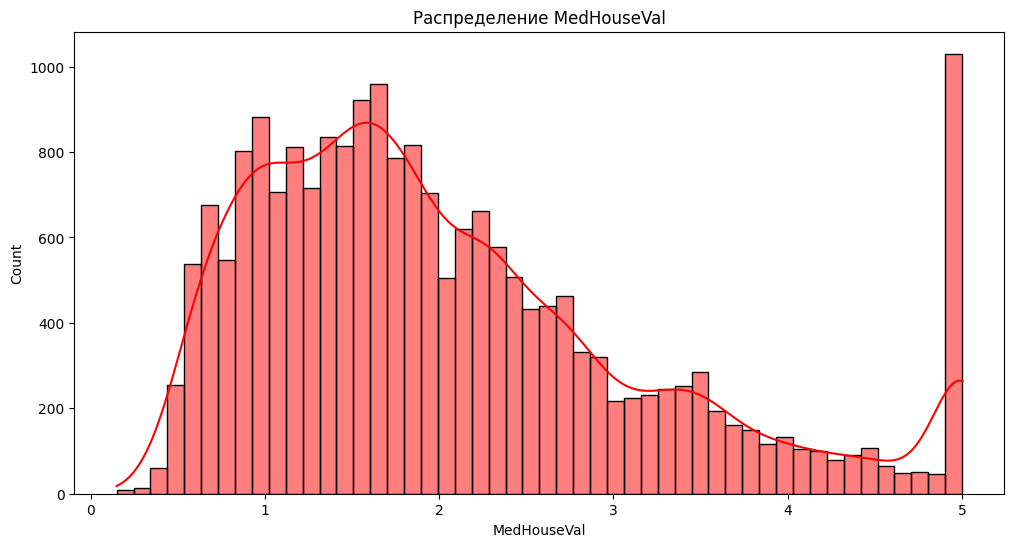

In [12]:
plt.figure(figsize=(12,6))
hist(plt)

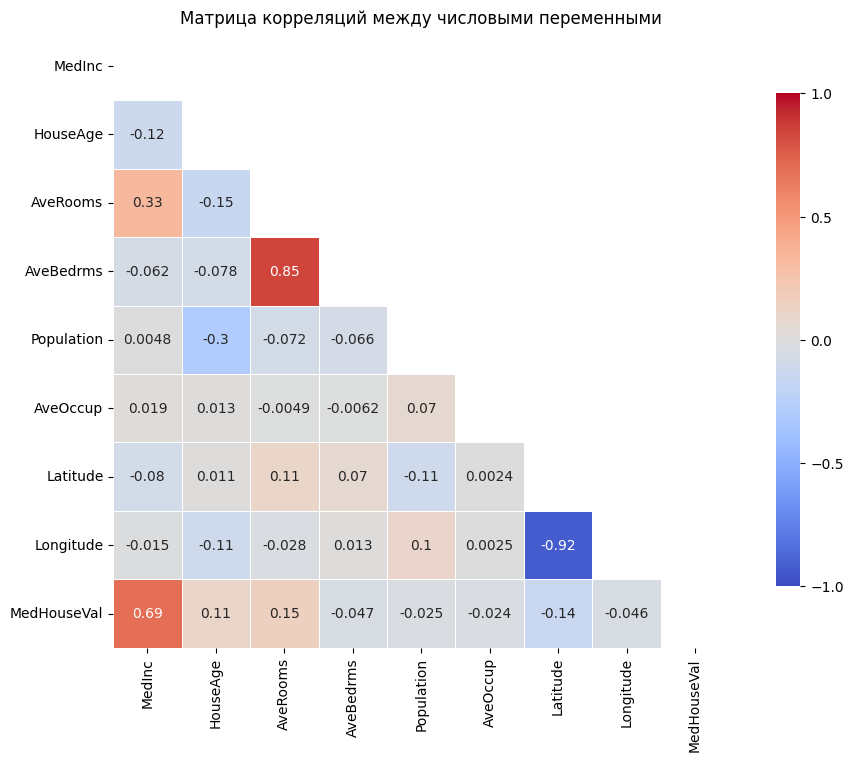

In [13]:
correlation_matrix=df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot_kws={"size": 10},
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()

In [14]:
X=df.drop('MedHouseVal', axis=1)
y=df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Обучение модели RandomForestRegressor

In [15]:
def random_forest_par(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):

    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=None if int(max_depth) == 0 else int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=float(max_features),
        random_state=42,
        n_jobs=-1
    )

    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    # Возвращаем среднее значение RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'n_estimators': (50, 320),
    'max_depth': (0, 20),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 5),
    'max_features': (0.1, 1.0)  # Пропорция от числа признаков
}

optimizer = BayesianOptimization( f=random_forest_par, pbounds=param_bounds, random_state=42, verbose=2)

optimizer.maximize(init_points=10, n_iter=30)
best_params_rf = optimizer.max['params']
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['max_depth'] = None if int(best_params_rf['max_depth']) == 0 else int(best_params_rf['max_depth'])
best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])
best_params_rf['max_features'] = float(best_params_rf['max_features'])


best_model_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)

def calculate_model_show_best_params(best_model=best_model_rf, name_model='RandomForestRegressor'):
    best_model.fit(X_train, y_train)
    best_train_preds = best_model.predict(X_train)
    best_train_rmse = np.sqrt(mean_squared_error(y_train, best_train_preds))
    print(f"Лучшие параметры {name_model}: {best_params_rf}")
    print(f"RMSE на обучающей выборке с лучшими параметрами: {best_train_rmse:.2f}")
    best_model_r2 = r2_score(y_train, best_train_preds)
    print(f"R2 на обучающей выборке с лучшими параметрами: {best_model_r2:.2f}")

calculate_model_show_best_params()

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.3559   | 7.491     | 0.9556    | 3.928     | 5.592     | 92.13     |
| 2         | -0.8557   | 3.12      | 0.1523    | 4.465     | 5.607     | 241.2     |
| 3         | -0.2627   | 0.4117    | 0.9729    | 4.33      | 3.274     | 99.09     |
| 4         | -0.6936   | 3.668     | 0.3738    | 3.099     | 4.592     | 128.6     |
| 5         | -0.3484   | 12.24     | 0.2255    | 2.169     | 4.198     | 173.1     |
| 6         | -0.2625   | 15.7      | 0.2797    | 3.057     | 5.554     | 62.54     |
| 7         | -0.2741   | 12.15     | 0.2535    | 1.26      | 7.693     | 310.7     |
| 8         | -0.2548   | 16.17     | 0.3742    | 1.391     | 6.105     | 168.8     |
| 9         | -0.7299   | 2.441     | 0.5457    | 1.138     | 7.456     | 119.9     |
| 10        | -0.2597   | 13.25     | 0.3805    | 3.08

GradientBoostingRegressor

In [19]:
def gradient_boosting_regressor_par(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, learning_rate):

    model =GradientBoostingRegressor(
        n_estimators=int(n_estimators),
        max_depth=None if int(max_depth) == 0 else int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=float(max_features),
        learning_rate=float(learning_rate),
        random_state=42
    )

    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=6)
    # Возвращаем среднее значение RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'n_estimators': (50, 250),
    'max_depth': (1, 32),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0),  # Пропорция от числа признаков
    'learning_rate': (0.01, 0.5)
}

optimizer = BayesianOptimization( f=gradient_boosting_regressor_par, pbounds=param_bounds, random_state=42, verbose=2)

optimizer.maximize(init_points=1, n_iter=1)
best_params_gbr= optimizer.max['params']
best_params_gbr['n_estimators'] = int(best_params_gbr['n_estimators'])
best_params_gbr['max_depth'] = None if int(best_params_gbr['max_depth']) == 0 else int(best_params_gbr['max_depth'])
best_params_gbr['min_samples_split'] = int(best_params_gbr['min_samples_split'])
best_params_gbr['min_samples_leaf'] = int(best_params_gbr['min_samples_leaf'])
best_params_gbr['max_features'] = float(best_params_gbr['max_features'])
best_params_gbr['learning_rate'] = float(best_params_gbr['learning_rate'])


best_model_gbr = GradientBoostingRegressor(**best_params_gbr, random_state=42)

calculate_model_show_best_params(best_model=best_model_gbr, name_model='GradientBoostingRegressor')

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -0.2847   | 0.1935    | 30.47     | 0.7588    | 2.796     | 2.936     | 81.2      |
| 2         | -0.3037   | 0.3792    | 27.58     | 0.6311    | 2.099     | 4.646     | 207.2     |
Лучшие параметры GradientBoostingRegressor: {'max_depth': 18, 'max_features': 0.3346552845899442, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 291}
RMSE на обучающей выборке с лучшими параметрами: 0.00
R2 на обучающей выборке с лучшими параметрами: 1.00


Оценка моделей:
Оцените производительность модели на тестовой выборке, используя метрики классификации, такие как точность, полнота и F1-мера.

In [20]:
def evaluate_model(model_name='RandomForestRegressor', best_model=best_model_rf):
    test_preds = best_model.predict(X_test)
    print(f'{model_name} metrics')
    print(f'Precision: {precision_score(y_test, test_preds)}')
    print(f'Recall: {recall_score(y_test, test_preds)}')
    print(f'F1-score: {f1_score(y_test, test_preds)}')

evaluate_model()
evaluate_model(model_name='GradientBoostingRegressor', best_model=best_model_gbr)

RandomForestRegressor metrics


ValueError: continuous is not supported

Модели практически одинаковы по исследуемым параметрам

Проведите сравнение результатов вашей модели со стандартной реализацией случайного леса из библиотеки scikit-learn.

In [21]:
model_standard_rf=RandomForestRegressor()
model_standard_rf.fit(X_train, y_train)
evaluate_model(model_name='Standard RandomForestRegressor', best_model=model_standard_rf)

Standard RandomForestRegressor metrics


ValueError: continuous is not supported